## **Fashion MNIST- MLP implementation from scratch**

In [20]:
import numpy as np
import pandas as pd
import math
import matplotlib.cm as cm 
import matplotlib.pyplot as plt

# Data Loading- Fashion MNIST dataset from Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_test = "/content/drive/MyDrive/Datasets/MNIST/fashion-mnist_test.csv"
test_data = pd.read_csv(path_test)

In [ ]:
path_train = "/content/drive/MyDrive/Datasets/MNIST/fashion-mnist_train.csv"
train_data = pd.read_csv(path_train)

In [ ]:
train_labels=np.array(train_data.loc[:,'label'])
train_data=np.array(train_data.loc[:,train_data.columns!='label'])

# Exploratory Data Analysis

## Data Visualization

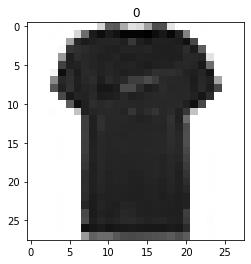

In [15]:
index=10;
plt.title((train_labels[index]))
plt.imshow(train_data[index].reshape(28,28), cmap=cm.binary)

## *Frequency* Calculator and Plots

In [16]:
print("Frequency Calculator and Plots")
y_value=np.zeros((1,10))
for i in range (10):
    print("occurance of ",i,"=",np.count_nonzero(train_labels==i))
    y_value[0,i-1]= np.count_nonzero(train_labels==i)

Frequency Calculator and Plots
occurance of  0 = 6000
occurance of  1 = 6000
occurance of  2 = 6000
occurance of  3 = 6000
occurance of  4 = 6000
occurance of  5 = 6000
occurance of  6 = 6000
occurance of  7 = 6000
occurance of  8 = 6000
occurance of  9 = 6000


<BarContainer object of 10 artists>

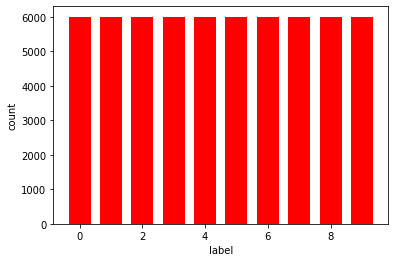

In [17]:
y_value=y_value.ravel()
x_value=[0,1,2,3,4,5,6,7,8,9]
plt.xlabel('label')
plt.ylabel('count')
plt.bar(x_value,y_value,0.7,color='r')

# Data Preprocessing

In [22]:
#converting train_label in one hot encoder representation 
train_data=np.reshape(train_data,[784,60000])
train_label=np.zeros((10,60000))
for col in range (60000):
    val=train_labels[col]
    for row in range (10):
        if (val==row):
            train_label[val,col]=1
print("train_data shape="+str(np.shape(train_data)))
print("train_label shape="+str(np.shape(train_label)))

train_data shape=(784, 60000)
train_label shape=(10, 60000)


# Activation Functions

In [41]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

In [42]:
def relu(Z):
    A = np.maximum(0,Z)    
    cache = Z 
    return A, cache

In [43]:
def softmax(Z):
    e_x = np.exp(Z)
    A= e_x / np.sum(np.exp(Z))  
    cache=Z
    return A,cache

In [44]:
def relu_derivative(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

In [45]:
def sigmoid_derivative(dA, cache):    
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ

In [62]:
def softmax_derivative(Z,cache):
    Z=cache
    length=10  
    dZ=np.zeros((60000,10))
    Z=np.transpose(Z)
    for row in range (0,60000):
            den=(np.sum(np.exp(Z[row,:])))*(np.sum(np.exp(Z[row,:])))
            for col in range (0,10):
                sums=0
                for j in range (0,10):
                    if (j!=col):
                        sums=sums+(math.exp(Z[row,j]))
                dZ[row,col]=(math.exp(Z[row,col])*sums)/den           
    dZ=np.transpose(dZ)
    Z=np.transpose(Z)

    #assert (dZ.shape == Z.shape)
    return dZ

# Weights and Bias intialization

In [27]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)            # number of layers in the network   
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))    
    return parameters

# Forward Propogation

In [47]:
def linear_forward(A, W, b):
    Z = np.dot(W,A) +b
    cache = (A, W, b)
    assert(Z.shape == (W.shape[0], A.shape[1]))
    return Z, cache

In [49]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        #print("Z="+str(Z))
        A, activation_cache = relu(Z) 
    elif activation == "softmax":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

In [50]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "softmax")
    caches.append(cache)               
    return AL, caches

In [51]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    return cost

# Back Propogation

In [52]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZ,A_prev.T)  
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True);
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

In [53]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_derivative(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)  
    elif activation == "sigmoid":
        dZ = sigmoid_derivative(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "softmax":
        dZ = softmax_derivative(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [54]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    M=len(layers_dims)
    current_cache = caches[M-2]
    grads["dA"+str(M-1)], grads["dW"+str(M-1)], grads["db"+str(M-1)] = linear_activation_backward(dAL, current_cache, activation = "softmax")#M-1
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [55]:
def update_parameters(parameters, grads, learning_rate):
    for l in range(len_update-1):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate*grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate*grads["db" + str(l+1)])
    return parameters

# Plots

In [56]:
def plot_graph(cost_plot):
    x_value=list(range(1,len(cost_plot)+1))
    plt.xlabel('iteration')
    plt.ylabel('cost')
    plt.plot(x_value,cost_plot,0.,color='g')

# MLP Architecture

In [57]:
layers_dims = [784,500,400,300,100,10] #  n-layer model (n=6 including input and output layer)
len_update=len(layers_dims)

In [58]:
def L_layer_model(X, Y, layers_dims, learning_rate , num_iterations , print_cost=False):
    print("training...")
    costs = []  
    cost_plot=np.zeros(num_iterations)
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost =compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate) 
        cost_plot[i]=cost;
    plot_graph(cost_plot)
    return parameters

training...
training done


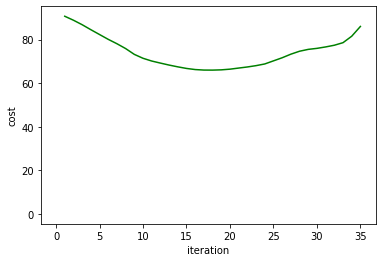

In [63]:
parameters = L_layer_model(train_data, train_label, layers_dims,learning_rate = 0.0005, num_iterations =35 , print_cost = True) 
print("training done")